# Generate lookup table for field rotation offsets

In [1]:
import numpy
import random

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.neighbors import KDTree

from astropy.io import fits
from astropy.table import join
from astropy import units as u

import desimodel.focalplane.geometry as geom
from desisim.templates import STD

/home/tyapici/anaconda/anaconda3/envs/dithering/lib/python3.6/site-packages/desispec-0.28.0.dev3299-py3.6.egg/desispec/maskbits.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """)


In [2]:
mpl.style.use("good_config")
generate_spectra = False

We load the test tile (tile 58060) for the focal coordinates. The flux values are also converted to the respective magnitudes.

In [3]:
orig_hdu = fits.open('../../../dithering-results/GAIA_tiles/tile-058060.fits')
orig_data = orig_hdu[1].data

proc_hdu = fits.open('../../../dithering-results/GAIA_tiles/tile58060_rot0.01_dithertest.fits')
proc_data = proc_hdu[1].data

# Join the offset and original tables.
joined_data = join(orig_data, proc_data, keys=['TARGETID', 'FIBER', 'LOCATION'])

# Add magnitude columns.
for band in ['G', 'R', 'Z']:
    joined_data['MAG_{}'.format(band)] = 22.5 - 2.5*numpy.log10(joined_data['FLUX_{}'.format(band)])

This is where the magic happens. Using the $\bf KDTree$, we find which fiber is on which petal. This information is later used to input the petal-dependant offsets. To assure that we get at least one fiber from the KDTree, we use a distance of 8 mm. This distance is arbitrarily chosen but returns at least one fiber from the query_radius method. When going over the devices (which are actually fiber ids), we only select the first one (since query is set to sort the results with respect to their distances).

In [4]:
rotation_angle = 0.01 * u.degree

x, y  = joined_data['DESIGN_X']*u.mm, joined_data['DESIGN_Y']*u.mm
flux_r= joined_data['FLUX_R']
mag_r = joined_data['MAG_R']

r     = numpy.sqrt(x**2+y**2)
angle = numpy.arctan2(y, x)
dr    = (numpy.tan(rotation_angle.to(u.radian)) * r).to(u.micron)
dx    = (-dr * numpy.sin(angle)).to(u.micron).value
dy    = ( dr * numpy.cos(angle)).to(u.micron).value

Here, we plot the generated offsets on the petals. It is also a good sanity check.

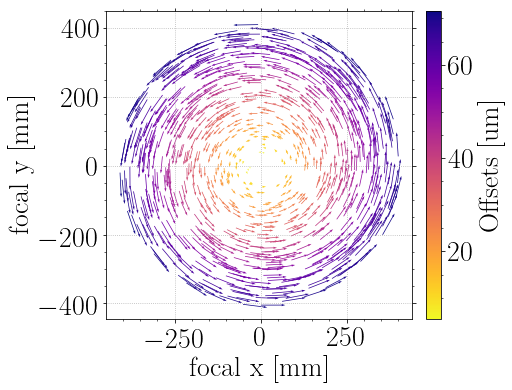

In [5]:
fig = plt.figure(figsize=(6,6))
plt.quiver(x.value, y.value, dx, dy, numpy.sqrt(dx**2+dy**2), scale=1, units='xy', cmap=mpl.cm.plasma_r)
plt.gca().set_aspect(1)
plt.xlabel(xlabel="focal x [mm]")
plt.ylabel(ylabel="focal y [mm]")
plt.colorbar(fraction=0.046, pad=0.04, label="Offsets [um]")
plt.savefig("figures/field_rotation_offsets.pdf", bbox_inches='tight')
plt.savefig("figures/field_rotation_offsets.png", bbox_inches='tight')
plt.show()

We need to generate star spectra for the fibers. We use $\texttt{desisim}$ for this.

In [6]:
if generate_spectra:
    starmaker = STD(minwave=3550., maxwave=9850.)
    nspec = len(mag_r)
    flux, wave, meta, objmeta = starmaker.make_templates(mag=mag_r, nmodel=nspec, south=False,
                                                         seed=numpy.random.randint(1, numpy.iinfo(numpy.int32).max))
    numpy.savez('outputs/spectra_template.npz',
             flux = flux,
             wave = wave, 
             meta = meta,
             objmeta = objmeta)
else:
    spectra_data = numpy.load("outputs/spectra_template.npz")
    flux, wave, meta, objmeta = spectra_data['flux'], spectra_data['wave'], spectra_data['meta'], spectra_data['objmeta']

# Save the file to use in the simulations

In [7]:
x_pos = []; y_pos = [];
x_offsets = []; y_offsets = [];
wlens = []; fluxes = [];
mags = [];

for i, _ in enumerate(joined_data):
    x_pos.append(joined_data['DESIGN_X'][i])
    y_pos.append(joined_data['DESIGN_Y'][i])
    x_offsets.append(dx[i])
    y_offsets.append(dy[i])
    mags.append([joined_data['MAG_G'][i], joined_data['MAG_R'][i], joined_data['MAG_Z'][i]])
    fluxes.append(flux[i].T.reshape(1, -1)[0])
    wlens.append(wave.reshape(1, -1)[0])
    if i % 100 == 0:
        print("{} out of {} done".format(i, len(joined_data)-1))

print("{} out of {} done".format(i, len(joined_data)-1))
        
numpy.savez('outputs/tabled_values_field_rotation.npz',
            x_pos=x_pos, y_pos=y_pos,
            x_offsets=x_offsets, y_offsets=y_offsets,
            wlens=wlens, fluxes=fluxes, 
            mags=mags, 
            tiledec=orig_hdu[1].header['TILEDEC'], tilera=orig_hdu[1].header['TILERA'])

0 out of 976 done
100 out of 976 done
200 out of 976 done
300 out of 976 done
400 out of 976 done
500 out of 976 done
600 out of 976 done
700 out of 976 done
800 out of 976 done
900 out of 976 done
976 out of 976 done
